In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import torch.nn.functional as F
from training_utils import double_std, plot_losses

import json
import statistics
from sklearn.metrics import f1_score
import pickle

import scipy.stats as sp

In [87]:
def plot_losses(save_directory):
    
    save_models = save_directory + '/save_models/'
    infile = open(save_directory + '/losses.pkl','rb')
    losses = pickle.load(infile)
    
    losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]

    plt.figure()
    losses[100:].plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
    plt.savefig(save_directory + '/loss.png')

    plt.figure()

In [131]:
def plot_results(save_directory, lr, pretrainings, n_trains, losses, save_file, plot_loss = False, last_epoch = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for run in runs :
                    if last_epoch and pretraining != 'baseline':
                        save_directory_name = save_directory + pretraining + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                             '_vol_in_train_2_vol_in_val_pretrainedEpoch1499/run_' + str(run)
                    else : 
                        save_directory_name = save_directory + pretraining + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                             '_vol_in_train_2_vol_in_val/run_' + str(run)
                    if plot_loss :
                        plot_losses(save_directory_name)
                    infile = open(save_directory_name + '/results.pkl','rb')
                    results_BN = pickle.load(infile)
                    results = results.append(results_BN)
    results_mean = results.groupby([ "n vol train", "loss unet", "model"]).agg([np.mean, double_std, sp.sem])
    #print(results_mean)
    results_test_f1 = results_mean['test F1']
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('trained_models/Cardiac_only/figures/'+ save_file +'.png', bbox_inches='tight')
    return results_test_f1, results


old

not test on full test set, test was changing between each run

global d had only 1 transformation

pretrain done on a only train not train + validation

averaged on less runs

save_directory = './trained_models/Cardiac_only_old/ACDC_8/'
runs = ['0','1', '2', '3', '4']#, '5']#, '6', '7', '8', '9']
pretrainings = ['baseline', 'pretrained with global_d', 'pretrained with global_dminus' ]
n_trains = [1, 2, 5, 8]
losses = [ 'crossentropy_loss']#''] #s',
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)

# Results ACDC

## Pretrain with 25 volumes VS 50 volumes (train+validation set)

### Global Dminus (Only a transformation is positive examples)

mean  \
n vol train loss unet         model                                                         
1           crossentropy_loss baseline                                           0.537645   
                              pretrained with ACDC (global_dminus)               0.543761   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.611080   
2           crossentropy_loss baseline                                           0.607555   
                              pretrained with ACDC (global_dminus)               0.603609   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.690500   
5           crossentropy_loss baseline                                           0.766953   
                              pretrained with ACDC (global_dminus)               0.789245   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.818331   
8           crossentropy_loss baseline                                           0.830891   
                              pretrained with ACDC (global_dminus)               0.809092   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.840626   

                                                                                 double_std  \
n vol train loss unet         model                                                           
1           crossentropy_loss baseline                                             0.246149   
                              pretrained with ACDC (global_dminus)                 0.198202   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.155280   
2           crossentropy_loss baseline                                             0.237397   
                              pretrained with ACDC (global_dminus)                 0.204372   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.200766   
5           crossentropy_loss baseline                                             0.102982   
                              pretrained with ACDC (global_dminus)                 0.102585   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.042135   
8           crossentropy_loss baseline                                             0.028487   
                              pretrained with ACDC (global_dminus)                 0.058751   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.029022   

                                                                                      sem  
n vol train loss unet         model                                                        
1           crossentropy_loss baseline                                           0.041025  
                              pretrained with ACDC (global_dminus)               0.033034  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.025880  
2           crossentropy_loss baseline                                           0.039566  
                              pretrained with ACDC (global_dminus)               0.034062  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.033461  
5           crossentropy_loss baseline                                           0.017164  
                              pretrained with ACDC (global_dminus)               0.017097  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.007022  
8           crossentropy_loss baseline                                           0.004748  
                              pretrained with ACDC (global_dminus)               0.009792  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.004837

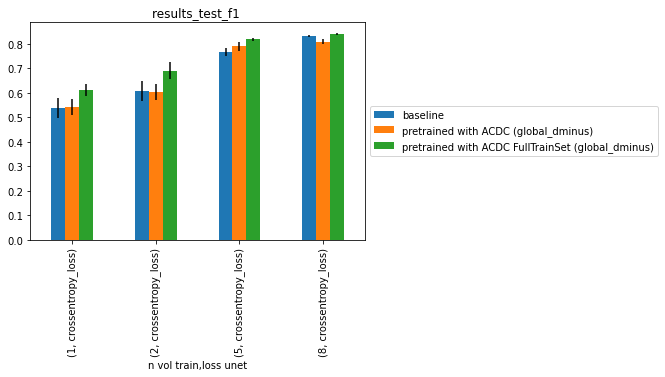

In [132]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

pretrainings = ['baseline', 
                'pretrained with ACDC (global_dminus)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

In [134]:
results.head(40)

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch,loss unet,test loss
0,baseline,1,0.001,NaN,0.846447,0.381574,0.546001,0.053868,0.110220,468,crossentropy_loss,0.207504
0,baseline,1,0.001,NaN,0.820863,0.393534,0.569735,0.082431,0.354907,307,crossentropy_loss,0.223883
0,baseline,1,0.001,NaN,0.898536,0.345244,0.452581,0.054196,0.359341,416,crossentropy_loss,0.231171
0,baseline,1,0.001,NaN,0.918474,0.741265,0.639535,0.050492,0.122774,432,crossentropy_loss,0.170315
0,baseline,1,0.001,NaN,0.895119,0.666507,0.679516,0.041568,0.052221,446,crossentropy_loss,0.168839
0,baseline,1,0.001,NaN,0.875015,0.215545,0.234342,0.038908,0.425277,459,crossentropy_loss,0.445657
0,baseline,1,0.001,NaN,0.914116,0.499304,0.574631,0.044581,0.223855,423,crossentropy_loss,0.187978
0,baseline,1,0.001,NaN,0.893120,0.645923,0.578669,0.046000,0.110779,462,crossentropy_loss,0.191726
0,baseline,1,0.001,NaN,0.853156,0.650442,0.457861,0.045660,0.117929,408,crossentropy_loss,0.255236
0,baseline,1,0.001,NaN,0.871576,0.706980,0.643573,0.056657,0.133198,349,crossentropy_loss,0.149924


### Global D (Include same partition as positive examples)

mean  \
n vol train loss unet         model                                                    
1           crossentropy_loss baseline                                      0.537645   
                              pretrained with ACDC (global_d)               0.553106   
                              pretrained with ACDC FullTrainSet (global_d)  0.614007   
2           crossentropy_loss baseline                                      0.607555   
                              pretrained with ACDC (global_d)               0.638089   
                              pretrained with ACDC FullTrainSet (global_d)  0.685753   
5           crossentropy_loss baseline                                      0.766953   
                              pretrained with ACDC (global_d)               0.790368   
                              pretrained with ACDC FullTrainSet (global_d)  0.817401   
8           crossentropy_loss baseline                                      0.830891   
                              pretrained with ACDC (global_d)               0.826524   
                              pretrained with ACDC FullTrainSet (global_d)  0.840535   

                                                                            double_std  \
n vol train loss unet         model                                                      
1           crossentropy_loss baseline                                        0.246149   
                              pretrained with ACDC (global_d)                 0.271682   
                              pretrained with ACDC FullTrainSet (global_d)    0.155339   
2           crossentropy_loss baseline                                        0.237397   
                              pretrained with ACDC (global_d)                 0.158353   
                              pretrained with ACDC FullTrainSet (global_d)    0.194993   
5           crossentropy_loss baseline                                        0.102982   
                              pretrained with ACDC (global_d)                 0.055692   
                              pretrained with ACDC FullTrainSet (global_d)    0.071756   
8           crossentropy_loss baseline                                        0.028487   
                              pretrained with ACDC (global_d)                 0.034663   
                              pretrained with ACDC FullTrainSet (global_d)    0.037622   

                                                                                 sem  
n vol train loss unet         model                                                   
1           crossentropy_loss baseline                                      0.041025  
                              pretrained with ACDC (global_d)               0.045280  
                              pretrained with ACDC FullTrainSet (global_d)  0.025890  
2           crossentropy_loss baseline                                      0.039566  
                              pretrained with ACDC (global_d)               0.026392  
                              pretrained with ACDC FullTrainSet (global_d)  0.032499  
5           crossentropy_loss baseline                                      0.017164  
                              pretrained with ACDC (global_d)               0.009282  
                              pretrained with ACDC FullTrainSet (global_d)  0.011959  
8           crossentropy_loss baseline                                      0.004748  
                              pretrained with ACDC (global_d)               0.005777  
                              pretrained with ACDC FullTrainSet (global_d)  0.006270

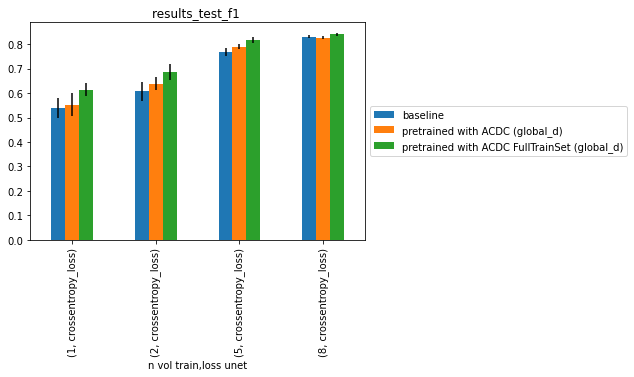

In [4]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC FullTrainSet (global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

## ACDC pretraining VS 4 datasets pretraining (ACDC, HCP, Chaos and MedDecat Prostate)

mean  \
n vol train loss unet         model                                                          
1           crossentropy_loss baseline                                            0.537645   
                              pretrained with 4 datasets (2 steps global_d)       0.525420   
                              pretrained with 4 datasets (global_d)               0.550824   
                              pretrained with 4 datasets (global_dminus)          0.562817   
                              pretrained with 4 datasets (representation_loss)    0.577280   
                              pretrained with ACDC FullTrainSet (global_d)        0.614007   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.611080   
                              pretrained with ACDC FullTrainSet (representati...  0.593302   
2           crossentropy_loss baseline                                            0.607555   
                              pretrained with 4 datasets (2 steps global_d)       0.640024   
                              pretrained with 4 datasets (global_d)               0.633553   
                              pretrained with 4 datasets (global_dminus)          0.690673   
                              pretrained with 4 datasets (representation_loss)    0.664306   
                              pretrained with ACDC FullTrainSet (global_d)        0.685753   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.690500   
                              pretrained with ACDC FullTrainSet (representati...  0.693825   
5           crossentropy_loss baseline                                            0.766953   
                              pretrained with 4 datasets (2 steps global_d)       0.797809   
                              pretrained with 4 datasets (global_d)               0.784999   
                              pretrained with 4 datasets (global_dminus)          0.792196   
                              pretrained with 4 datasets (representation_loss)    0.793370   
                              pretrained with ACDC FullTrainSet (global_d)        0.817401   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.818331   
                              pretrained with ACDC FullTrainSet (representati...  0.808264   
8           crossentropy_loss baseline                                            0.830891   
                              pretrained with 4 datasets (2 steps global_d)       0.834299   
                              pretrained with 4 datasets (global_d)               0.837739   
                              pretrained with 4 datasets (global_dminus)          0.836238   
                              pretrained with 4 datasets (representation_loss)    0.835726   
                              pretrained with ACDC FullTrainSet (global_d)        0.840535   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.840626   
                              pretrained with ACDC FullTrainSet (representati...  0.853875   

                                                                                  double_std  \
n vol train loss unet         model                                                            
1           crossentropy_loss baseline                                              0.246149   
                              pretrained with 4 datasets (2 steps global_d)         0.193984   
                              pretrained with 4 datasets (global_d)                 0.186574   
                              pretrained with 4 datasets (global_dminus)            0.220888   
                              pretrained with 4 datasets (representation_loss)      0.214649   
                              pretrained with ACDC FullTrainSet (global_d)          0.155339   
                              pretrained with ACDC FullTrainSet (global_dminus)     0.155280   
                         

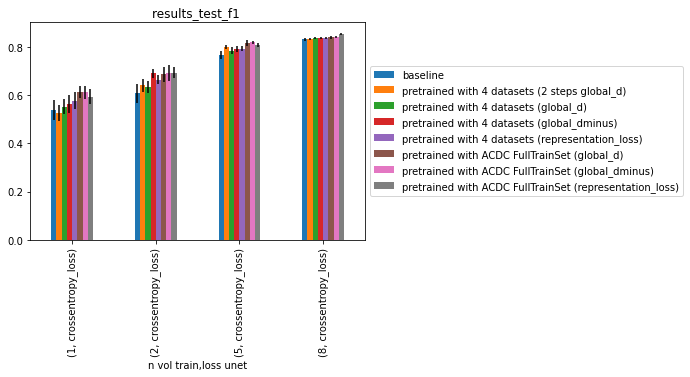

In [31]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with ACDC FullTrainSet (representation_loss)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss)',
                'pretrained with 4 datasets (2 steps global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

## Global D VS Global Dminus

mean  \
n vol train loss unet         model                                                         
1           crossentropy_loss baseline                                           0.537645   
                              pretrained with 4 datasets (global_d)              0.550824   
                              pretrained with 4 datasets (global_dminus)         0.562817   
                              pretrained with ACDC FullTrainSet (global_d)       0.614007   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.611080   
2           crossentropy_loss baseline                                           0.607555   
                              pretrained with 4 datasets (global_d)              0.633553   
                              pretrained with 4 datasets (global_dminus)         0.690673   
                              pretrained with ACDC FullTrainSet (global_d)       0.685753   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.690500   
5           crossentropy_loss baseline                                           0.766953   
                              pretrained with 4 datasets (global_d)              0.784999   
                              pretrained with 4 datasets (global_dminus)         0.792196   
                              pretrained with ACDC FullTrainSet (global_d)       0.817401   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.818331   
8           crossentropy_loss baseline                                           0.830891   
                              pretrained with 4 datasets (global_d)              0.837739   
                              pretrained with 4 datasets (global_dminus)         0.836238   
                              pretrained with ACDC FullTrainSet (global_d)       0.840535   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.840626   

                                                                                 double_std  \
n vol train loss unet         model                                                           
1           crossentropy_loss baseline                                             0.246149   
                              pretrained with 4 datasets (global_d)                0.186574   
                              pretrained with 4 datasets (global_dminus)           0.220888   
                              pretrained with ACDC FullTrainSet (global_d)         0.155339   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.155280   
2           crossentropy_loss baseline                                             0.237397   
                              pretrained with 4 datasets (global_d)                0.144611   
                              pretrained with 4 datasets (global_dminus)           0.112143   
                              pretrained with ACDC FullTrainSet (global_d)         0.194993   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.200766   
5           crossentropy_loss baseline                                             0.102982   
                              pretrained with 4 datasets (global_d)                0.076131   
                              pretrained with 4 datasets (global_dminus)           0.077008   
                              pretrained with ACDC FullTrainSet (global_d)         0.071756   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.042135   
8           crossentropy_loss baseline                                             0.028487   
                              pretrained with 4 datasets (global_d)                0.030852   
                              pretrained with 4 datasets (global_dminus)           0.023827   
                              pretrained with ACDC FullTrainSet (global_d)         0.037622   
                              pretrained wi

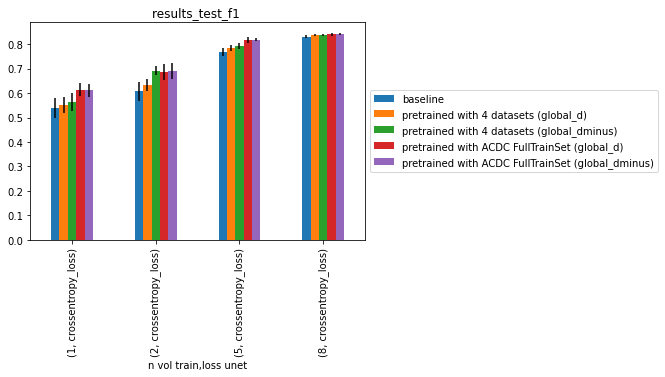

In [30]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

### Global Dminus 1 VS 4 datasets 

mean  \
n vol train loss unet         model                                                         
1           crossentropy_loss baseline                                           0.537645   
                              pretrained with 4 datasets (global_dminus)         0.562817   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.611080   
2           crossentropy_loss baseline                                           0.607555   
                              pretrained with 4 datasets (global_dminus)         0.690673   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.690500   
5           crossentropy_loss baseline                                           0.766953   
                              pretrained with 4 datasets (global_dminus)         0.792196   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.818331   
8           crossentropy_loss baseline                                           0.830891   
                              pretrained with 4 datasets (global_dminus)         0.836238   
                              pretrained with ACDC FullTrainSet (global_dminus)  0.840626   

                                                                                 double_std  \
n vol train loss unet         model                                                           
1           crossentropy_loss baseline                                             0.246149   
                              pretrained with 4 datasets (global_dminus)           0.220888   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.155280   
2           crossentropy_loss baseline                                             0.237397   
                              pretrained with 4 datasets (global_dminus)           0.112143   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.200766   
5           crossentropy_loss baseline                                             0.102982   
                              pretrained with 4 datasets (global_dminus)           0.077008   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.042135   
8           crossentropy_loss baseline                                             0.028487   
                              pretrained with 4 datasets (global_dminus)           0.023827   
                              pretrained with ACDC FullTrainSet (global_dminus)    0.029022   

                                                                                      sem  
n vol train loss unet         model                                                        
1           crossentropy_loss baseline                                           0.041025  
                              pretrained with 4 datasets (global_dminus)         0.036815  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.025880  
2           crossentropy_loss baseline                                           0.039566  
                              pretrained with 4 datasets (global_dminus)         0.018691  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.033461  
5           crossentropy_loss baseline                                           0.017164  
                              pretrained with 4 datasets (global_dminus)         0.012835  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.007022  
8           crossentropy_loss baseline                                           0.004748  
                              pretrained with 4 datasets (global_dminus)         0.003971  
                              pretrained with ACDC FullTrainSet (global_dminus)  0.004837

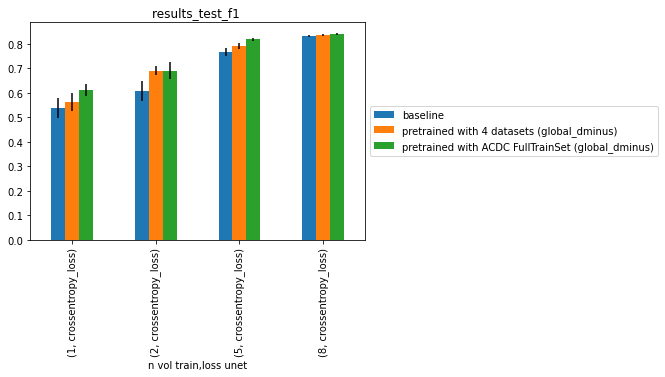

In [29]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with 4 datasets (global_dminus)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

### Global D 1 VS 4 datasets 

mean  \
n vol train loss unet         model                                                    
1           crossentropy_loss baseline                                      0.537645   
                              pretrained with 4 datasets (global_d)         0.550824   
                              pretrained with ACDC FullTrainSet (global_d)  0.614007   
2           crossentropy_loss baseline                                      0.607555   
                              pretrained with 4 datasets (global_d)         0.633553   
                              pretrained with ACDC FullTrainSet (global_d)  0.685753   
5           crossentropy_loss baseline                                      0.766953   
                              pretrained with 4 datasets (global_d)         0.784999   
                              pretrained with ACDC FullTrainSet (global_d)  0.817401   
8           crossentropy_loss baseline                                      0.830891   
                              pretrained with 4 datasets (global_d)         0.837739   
                              pretrained with ACDC FullTrainSet (global_d)  0.840535   

                                                                            double_std  \
n vol train loss unet         model                                                      
1           crossentropy_loss baseline                                        0.246149   
                              pretrained with 4 datasets (global_d)           0.186574   
                              pretrained with ACDC FullTrainSet (global_d)    0.155339   
2           crossentropy_loss baseline                                        0.237397   
                              pretrained with 4 datasets (global_d)           0.144611   
                              pretrained with ACDC FullTrainSet (global_d)    0.194993   
5           crossentropy_loss baseline                                        0.102982   
                              pretrained with 4 datasets (global_d)           0.076131   
                              pretrained with ACDC FullTrainSet (global_d)    0.071756   
8           crossentropy_loss baseline                                        0.028487   
                              pretrained with 4 datasets (global_d)           0.030852   
                              pretrained with ACDC FullTrainSet (global_d)    0.037622   

                                                                                 sem  
n vol train loss unet         model                                                   
1           crossentropy_loss baseline                                      0.041025  
                              pretrained with 4 datasets (global_d)         0.031096  
                              pretrained with ACDC FullTrainSet (global_d)  0.025890  
2           crossentropy_loss baseline                                      0.039566  
                              pretrained with 4 datasets (global_d)         0.024102  
                              pretrained with ACDC FullTrainSet (global_d)  0.032499  
5           crossentropy_loss baseline                                      0.017164  
                              pretrained with 4 datasets (global_d)         0.012688  
                              pretrained with ACDC FullTrainSet (global_d)  0.011959  
8           crossentropy_loss baseline                                      0.004748  
                              pretrained with 4 datasets (global_d)         0.005142  
                              pretrained with ACDC FullTrainSet (global_d)  0.006270

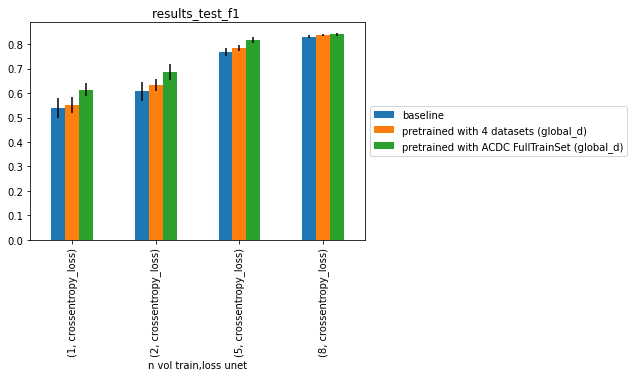

In [28]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with 4 datasets (global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

### 2 steps Global D : compute loss contrasting between dataset + within each dataset, between partitions

mean  \
n vol train loss unet         model                                                     
1           crossentropy_loss baseline                                       0.537645   
                              pretrained with 4 datasets (2 steps global_d)  0.525420   
                              pretrained with 4 datasets (global_d)          0.550824   
                              pretrained with ACDC FullTrainSet (global_d)   0.614007   
2           crossentropy_loss baseline                                       0.607555   
                              pretrained with 4 datasets (2 steps global_d)  0.640024   
                              pretrained with 4 datasets (global_d)          0.633553   
                              pretrained with ACDC FullTrainSet (global_d)   0.685753   
5           crossentropy_loss baseline                                       0.766953   
                              pretrained with 4 datasets (2 steps global_d)  0.797809   
                              pretrained with 4 datasets (global_d)          0.784999   
                              pretrained with ACDC FullTrainSet (global_d)   0.817401   
8           crossentropy_loss baseline                                       0.830891   
                              pretrained with 4 datasets (2 steps global_d)  0.834299   
                              pretrained with 4 datasets (global_d)          0.837739   
                              pretrained with ACDC FullTrainSet (global_d)   0.840535   

                                                                             double_std  \
n vol train loss unet         model                                                       
1           crossentropy_loss baseline                                         0.246149   
                              pretrained with 4 datasets (2 steps global_d)    0.193984   
                              pretrained with 4 datasets (global_d)            0.186574   
                              pretrained with ACDC FullTrainSet (global_d)     0.155339   
2           crossentropy_loss baseline                                         0.237397   
                              pretrained with 4 datasets (2 steps global_d)    0.165343   
                              pretrained with 4 datasets (global_d)            0.144611   
                              pretrained with ACDC FullTrainSet (global_d)     0.194993   
5           crossentropy_loss baseline                                         0.102982   
                              pretrained with 4 datasets (2 steps global_d)    0.048475   
                              pretrained with 4 datasets (global_d)            0.076131   
                              pretrained with ACDC FullTrainSet (global_d)     0.071756   
8           crossentropy_loss baseline                                         0.028487   
                              pretrained with 4 datasets (2 steps global_d)    0.024929   
                              pretrained with 4 datasets (global_d)            0.030852   
                              pretrained with ACDC FullTrainSet (global_d)     0.037622   

                                                                                  sem  
n vol train loss unet         model                                                    
1           crossentropy_loss baseline                                       0.041025  
                              pretrained with 4 datasets (2 steps global_d)  0.032331  
                              pretrained with 4 datasets (global_d)          0.031096  
                              pretrained with ACDC FullTrainSet (global_d)   0.025890  
2           crossentropy_loss baseline                                       0.039566  
                              pretrained with 4 datasets (2 steps global_d)  0.027557  
                              pretrained with 4 datasets (global_d)          0.024102  
                              pretrained with A

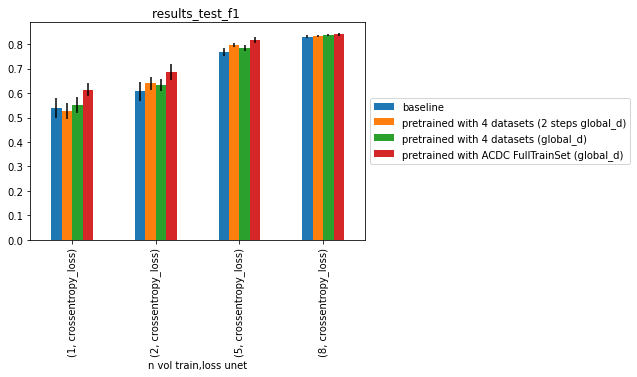

In [27]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

#### Representation loss : Compute loss one layer before the last dense layer and add it to the regular global d loss

mean  \
n vol train loss unet         model                                                          
1           crossentropy_loss baseline                                            0.537645   
                              pretrained with 4 datasets (global_d)               0.550824   
                              pretrained with 4 datasets (representation_loss)    0.577280   
                              pretrained with ACDC FullTrainSet (global_d)        0.614007   
                              pretrained with ACDC FullTrainSet (representati...  0.593302   
2           crossentropy_loss baseline                                            0.607555   
                              pretrained with 4 datasets (global_d)               0.633553   
                              pretrained with 4 datasets (representation_loss)    0.664306   
                              pretrained with ACDC FullTrainSet (global_d)        0.685753   
                              pretrained with ACDC FullTrainSet (representati...  0.693825   
5           crossentropy_loss baseline                                            0.766953   
                              pretrained with 4 datasets (global_d)               0.784999   
                              pretrained with 4 datasets (representation_loss)    0.793370   
                              pretrained with ACDC FullTrainSet (global_d)        0.817401   
                              pretrained with ACDC FullTrainSet (representati...  0.808264   
8           crossentropy_loss baseline                                            0.830891   
                              pretrained with 4 datasets (global_d)               0.837739   
                              pretrained with 4 datasets (representation_loss)    0.835726   
                              pretrained with ACDC FullTrainSet (global_d)        0.840535   
                              pretrained with ACDC FullTrainSet (representati...  0.853875   

                                                                                  double_std  \
n vol train loss unet         model                                                            
1           crossentropy_loss baseline                                              0.246149   
                              pretrained with 4 datasets (global_d)                 0.186574   
                              pretrained with 4 datasets (representation_loss)      0.214649   
                              pretrained with ACDC FullTrainSet (global_d)          0.155339   
                              pretrained with ACDC FullTrainSet (representati...    0.188302   
2           crossentropy_loss baseline                                              0.237397   
                              pretrained with 4 datasets (global_d)                 0.144611   
                              pretrained with 4 datasets (representation_loss)      0.119839   
                              pretrained with ACDC FullTrainSet (global_d)          0.194993   
                              pretrained with ACDC FullTrainSet (representati...    0.133185   
5           crossentropy_loss baseline                                              0.102982   
                              pretrained with 4 datasets (global_d)                 0.076131   
                              pretrained with 4 datasets (representation_loss)      0.064705   
                              pretrained with ACDC FullTrainSet (global_d)          0.071756   
                              pretrained with ACDC FullTrainSet (representati...    0.051804   
8           crossentropy_loss baseline                                              0.028487   
                              pretrained with 4 datasets (global_d)                 0.030852   
                              pretrained with 4 datasets (representation_loss)      0.024175   
                              pretrained with ACDC FullTrainSet (global_d)          0.037622   
 

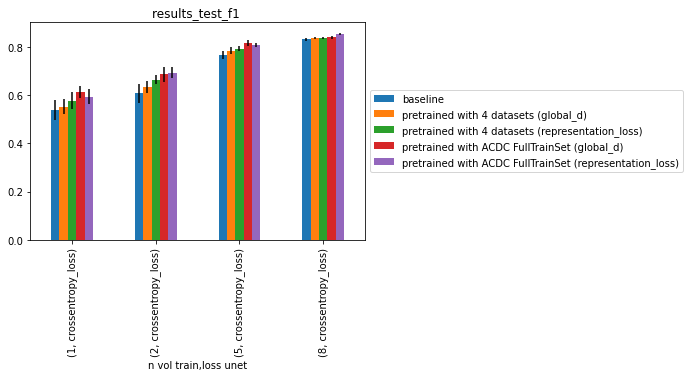

In [26]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (representation_loss)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

### 4 datasets competition

mean  \
n vol train loss unet         model                                                        
1           crossentropy_loss baseline                                          0.537645   
                              pretrained with 4 datasets (2 steps global_d)     0.525420   
                              pretrained with 4 datasets (global_d)             0.550824   
                              pretrained with 4 datasets (global_dminus)        0.562817   
                              pretrained with 4 datasets (representation_loss)  0.577280   
2           crossentropy_loss baseline                                          0.607555   
                              pretrained with 4 datasets (2 steps global_d)     0.640024   
                              pretrained with 4 datasets (global_d)             0.633553   
                              pretrained with 4 datasets (global_dminus)        0.690673   
                              pretrained with 4 datasets (representation_loss)  0.664306   
5           crossentropy_loss baseline                                          0.766953   
                              pretrained with 4 datasets (2 steps global_d)     0.797809   
                              pretrained with 4 datasets (global_d)             0.784999   
                              pretrained with 4 datasets (global_dminus)        0.792196   
                              pretrained with 4 datasets (representation_loss)  0.793370   
8           crossentropy_loss baseline                                          0.830891   
                              pretrained with 4 datasets (2 steps global_d)     0.834299   
                              pretrained with 4 datasets (global_d)             0.837739   
                              pretrained with 4 datasets (global_dminus)        0.836238   
                              pretrained with 4 datasets (representation_loss)  0.835726   

                                                                                double_std  \
n vol train loss unet         model                                                          
1           crossentropy_loss baseline                                            0.246149   
                              pretrained with 4 datasets (2 steps global_d)       0.193984   
                              pretrained with 4 datasets (global_d)               0.186574   
                              pretrained with 4 datasets (global_dminus)          0.220888   
                              pretrained with 4 datasets (representation_loss)    0.214649   
2           crossentropy_loss baseline                                            0.237397   
                              pretrained with 4 datasets (2 steps global_d)       0.165343   
                              pretrained with 4 datasets (global_d)               0.144611   
                              pretrained with 4 datasets (global_dminus)          0.112143   
                              pretrained with 4 datasets (representation_loss)    0.119839   
5           crossentropy_loss baseline                                            0.102982   
                              pretrained with 4 datasets (2 steps global_d)       0.048475   
                              pretrained with 4 datasets (global_d)               0.076131   
                              pretrained with 4 datasets (global_dminus)          0.077008   
                              pretrained with 4 datasets (representation_loss)    0.064705   
8           crossentropy_loss baseline                                            0.028487   
                              pretrained with 4 datasets (2 steps global_d)       0.024929   
                              pretrained with 4 datasets (global_d)               0.030852   
                              pretrained with 4 datasets (global_dminus)          0.023827   
                              pretrained with 4 datasets (representation_loss)    0.0

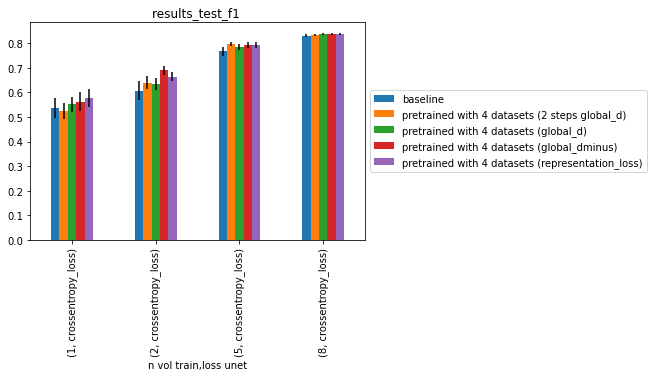

In [25]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss)',
                'pretrained with 4 datasets (2 steps global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

# Results CIMAS,  ACDC pretraining and 4 datasets pretraining

save_directory = './trained_models/Cardiac_only_old/CIMAS_8/'
pretrainings = ['baseline', 'pretrained with global_d',
                'pretrained with mixed_loss', 
                #'pretrained with ACDC FullTrainSet (representation_loss)',
                #'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (global_dminus)',
                #'pretrained with 4 datasets (global_d)',
                #'pretrained with 4 datasets (representation_loss)',
               ]
n_trains = [1,5]
losses =  ['crossentropy_loss']
lr = 0.001
     
runs = [ '0','1', '2', '3', '4']#, '5', '6', '7', '8', '9']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses, '/CIMAS_results_f1', plot_loss = False)
results_test_f1


save_directory = './trained_models/Cardiac_only_wrong_preprocessing/CIMAS/'
pretrainings = ['baseline', 'pretrained with global_d',
                'pretrained with global_dminus', 
                'pretrained with global_d 4 datasets',
                #'pretrained with ACDC FullTrainSet (representation_loss)',
                #'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (global_dminus)',
                #'pretrained with 4 datasets (global_d)',
                #'pretrained with 4 datasets (representation_loss)',
               ]
n_trains = [1,2,5]
losses =  ['mixed_dice_crossentropy_loss']
lr = 0.001
     
runs = [ '0','1', '2', '3', '4']#, '5', '6', '7', '8', '9']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses, '/CIMAS_results_f1', plot_loss = False)
results_test_f1

mean  \
n vol train loss unet         model                                                          
1           crossentropy_loss baseline                                            0.516844   
                              pretrained with 4 datasets (2 steps global_d)       0.501054   
                              pretrained with ACDC FullTrainSet (global_d)        0.486323   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.497306   
                              pretrained with ACDC FullTrainSet (representati...  0.464155   
2           crossentropy_loss baseline                                            0.520189   
                              pretrained with 4 datasets (2 steps global_d)       0.505945   
                              pretrained with ACDC FullTrainSet (global_d)        0.506029   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.511112   
                              pretrained with ACDC FullTrainSet (representati...  0.475651   
5           crossentropy_loss baseline                                            0.587635   
                              pretrained with 4 datasets (2 steps global_d)       0.583145   
                              pretrained with ACDC FullTrainSet (global_d)        0.608209   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.602464   
                              pretrained with ACDC FullTrainSet (representati...  0.602968   

                                                                                  double_std  \
n vol train loss unet         model                                                            
1           crossentropy_loss baseline                                              0.070370   
                              pretrained with 4 datasets (2 steps global_d)         0.085205   
                              pretrained with ACDC FullTrainSet (global_d)          0.122831   
                              pretrained with ACDC FullTrainSet (global_dminus)     0.098498   
                              pretrained with ACDC FullTrainSet (representati...    0.419292   
2           crossentropy_loss baseline                                              0.178059   
                              pretrained with 4 datasets (2 steps global_d)         0.129184   
                              pretrained with ACDC FullTrainSet (global_d)          0.169564   
                              pretrained with ACDC FullTrainSet (global_dminus)     0.134573   
                              pretrained with ACDC FullTrainSet (representati...    0.181172   
5           crossentropy_loss baseline                                              0.105473   
                              pretrained with 4 datasets (2 steps global_d)         0.133644   
                              pretrained with ACDC FullTrainSet (global_d)          0.107612   
                              pretrained with ACDC FullTrainSet (global_dminus)     0.124878   
                              pretrained with ACDC FullTrainSet (representati...    0.135390   

                                                                                       sem  
n vol train loss unet         model                                                         
1           crossentropy_loss baseline                                            0.015735  
                              pretrained with 4 datasets (2 steps global_d)       0.019052  
                              pretrained with ACDC FullTrainSet (global_d)        0.027466  
                              pretrained with ACDC FullTrainSet (global_dminus)   0.022025  
                              pretrained with ACDC FullTrainSet (representati...  0.093757  
2           crossentropy_loss baseline                                            0.039815  
                              pretrained with 4 datasets (2 steps global_d)       0.028886  
                 

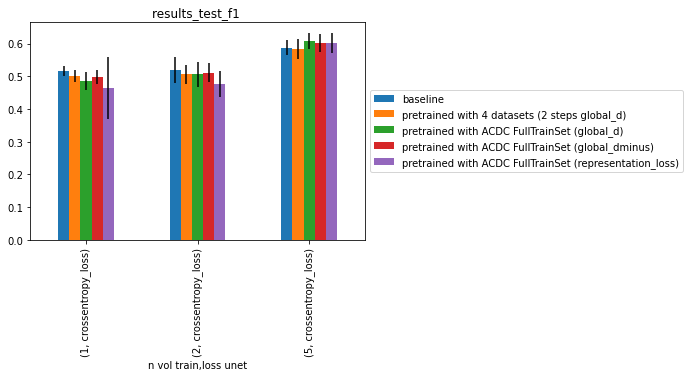

In [81]:
save_directory = './trained_models/Cardiac_only/CIMAS/'
pretrainings = ['baseline', 'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with ACDC FullTrainSet (representation_loss)',
                'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (global_dminus)',
                #'pretrained with 4 datasets (global_d)',
                #'pretrained with 4 datasets (representation_loss)',
               ]
n_trains = [1, 2, 5]
losses =  ['crossentropy_loss']
lr = 0.001
     
runs = [ '0','1', '2', '3', '4', '5']#, '6', '7', '8', '9']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses, '/CIMAS_results_f1', plot_loss = False)
results_test_f1

In [69]:
results.loc[results['model'] == 'pretrained with ACDC FullTrainSet (representation_loss)']

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch,loss unet,test loss
0,pretrained with ACDC FullTrainSet (representat...,1,0.001,NaN,0.879692,0.678238,0.568781,0.021216,0.044004,434,crossentropy_loss,0.079530
0,pretrained with ACDC FullTrainSet (representat...,1,0.001,NaN,0.000000,0.000000,0.000000,0.095332,0.153512,283,crossentropy_loss,0.146757
0,pretrained with ACDC FullTrainSet (representat...,1,0.001,NaN,0.862295,0.678071,0.587312,0.020843,0.041034,370,crossentropy_loss,0.080638
0,pretrained with ACDC FullTrainSet (representat...,1,0.001,NaN,0.772119,0.587040,0.496732,0.020212,0.052790,372,crossentropy_loss,0.094969
0,pretrained with ACDC FullTrainSet (representat...,1,0.001,NaN,0.852495,0.651968,0.553266,0.022955,0.055932,424,crossentropy_loss,0.094308
0,pretrained with ACDC FullTrainSet (representat...,1,0.001,NaN,0.906270,0.669697,0.578839,0.020069,0.030027,359,crossentropy_loss,0.085870
0,pretrained with ACDC FullTrainSet (representat...,2,0.001,NaN,0.891885,0.701514,0.593807,0.019315,0.034257,497,crossentropy_loss,0.085067
0,pretrained with ACDC FullTrainSet (representat...,2,0.001,NaN,0.833681,0.411087,0.511162,0.044820,0.128631,77,crossentropy_loss,0.107311
0,pretrained with ACDC FullTrainSet (representat...,2,0.001,NaN,0.839740,0.709098,0.471306,0.023487,0.034953,382,crossentropy_loss,0.113617
0,pretrained with ACDC FullTrainSet (representat...,2,0.001,NaN,0.883919,0.722384,0.351500,0.016778,0.036289,450,crossentropy_loss,0.188455


mean  \
n vol train loss unet         model                                                          
1           crossentropy_loss baseline                                            0.495696   
                              pretrained with 4 datasets (2 steps global_d)       0.475017   
                              pretrained with 4 datasets (global_d)               0.475692   
                              pretrained with 4 datasets (global_dminus)          0.487442   
                              pretrained with 4 datasets (representation_loss)    0.470274   
                              pretrained with ACDC FullTrainSet (global_d)        0.471868   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.481217   
                              pretrained with ACDC FullTrainSet (representati...  0.452965   
2           crossentropy_loss baseline                                            0.553126   
                              pretrained with 4 datasets (2 steps global_d)       0.542225   
                              pretrained with 4 datasets (global_d)               0.528853   
                              pretrained with 4 datasets (global_dminus)          0.535371   
                              pretrained with 4 datasets (representation_loss)    0.513252   
                              pretrained with ACDC FullTrainSet (global_d)        0.539750   
                              pretrained with ACDC FullTrainSet (global_dminus)   0.539413   
                              pretrained with ACDC FullTrainSet (representati...  0.517081   

                                                                                  double_std  \
n vol train loss unet         model                                                            
1           crossentropy_loss baseline                                              0.272585   
                              pretrained with 4 datasets (2 steps global_d)         0.264174   
                              pretrained with 4 datasets (global_d)                 0.320380   
                              pretrained with 4 datasets (global_dminus)            0.277253   
                              pretrained with 4 datasets (representation_loss)      0.245610   
                              pretrained with ACDC FullTrainSet (global_d)          0.265885   
                              pretrained with ACDC FullTrainSet (global_dminus)     0.247023   
                              pretrained with ACDC FullTrainSet (representati...    0.408947   
2           crossentropy_loss baseline                                              0.162561   
                              pretrained with 4 datasets (2 steps global_d)         0.143444   
                              pretrained with 4 datasets (global_d)                 0.143494   
                              pretrained with 4 datasets (global_dminus)            0.154446   
                              pretrained with 4 datasets (representation_loss)      0.176549   
                              pretrained with ACDC FullTrainSet (global_d)          0.159172   
                              pretrained with ACDC FullTrainSet (global_dminus)     0.135011   
                              pretrained with ACDC FullTrainSet (representati...    0.178597   

                                                                                       sem  
n vol train loss unet         model                                                         
1           crossentropy_loss baseline                                            0.045431  
                              pretrained with 4 datasets (2 steps global_d)       0.044029  
                              pretrained with 4 datasets (global_d)               0.053397  
                              pretrained with 4 datasets (global_dminus)          0.046209  
                              pretrained with 4 datasets (representation_loss)    0.040935  
             

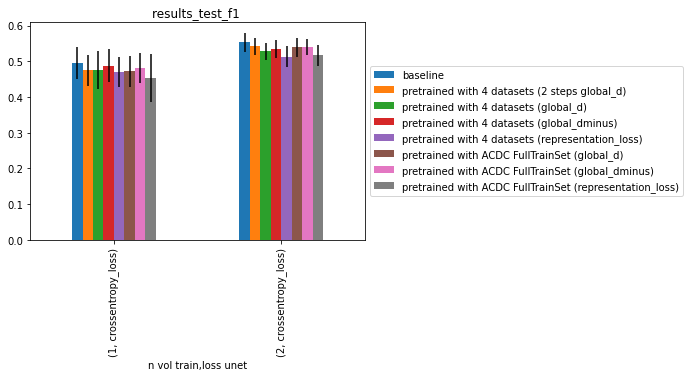

In [67]:
save_directory = './trained_models/Cardiac_only/CIMAS/'
pretrainings = ['baseline', 'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with ACDC FullTrainSet (representation_loss)',
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss)',
               ]
n_trains = [1, 2]
losses =  ['crossentropy_loss']
lr = 0.001
     
runs = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, losses, '/CIMAS_results_f1', plot_loss = False)
results_test_f1